In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [9]:
def resample(df, Ts:float|np.ndarray, start_ts:float,end_ts:float=None, method = "nearest"):
    """ Simple function to resample a dataframe with a given timesteps/frequency.

    Args:
        df (pd.DataFrame): Dataframe to resample. Must have a column "Time", all other columns are resampled and interpolated
        Ts (float|np.ndarray): Timestep or array of timesteps to resample to.
        start_ts (float): Start time of the resampling
        end_ts (float, optional): End time of the resampling. If None, the end time of the dataframe is used. Defaults to None.
        method (str, optional): Interpolation method. "nearest" or "linear". Defaults to "nearest".
    """
    
    time = df.Time.to_numpy()
    data = df.iloc[:, 1:].to_numpy() 
    if end_ts is None:
        end_ts = time.max()
    print("Interpolating with Ts step ", Ts, " for ", end_ts -start_ts, "s using interpolation method", method)
        
    valid = time >= start_ts 
    valid = valid * (time < end_ts)
    
    data = data[valid, :]
    time = time[valid]
    subsampled = []
    subsampled_ts = []
    if isinstance(Ts, float):
        num_steps = np.ceil((end_ts - start_ts) / Ts) + 1
        timestamps = np.arange(num_steps) * Ts + start_ts
    else:
        timestamps = Ts
        Ts = np.mean(np.diff(Ts))

    timestamp_idx = 0
    start_ts = timestamps[timestamp_idx]
    
    while start_ts < end_ts:
        
        if method == "nearest":
            closest_idx = np.argmin(np.abs(time - start_ts))
            closest = time[closest_idx]
            if (np.abs(closest - start_ts) < 0.5*Ts):
                subsampled.append(data[closest_idx, :])
            else:
                print(f"Could not Interpolate for Time:  {start_ts} closest timestep too far away ({np.abs(closest - start_ts):.4f}s)")
                subsampled.append(data[closest_idx, :]*np.NaN)
        elif method == "linear":
            closest_idxs = np.argsort(np.abs(time - start_ts))[:2]
            closest_idxs = np.sort(closest_idxs)
            closest_pts = time[closest_idxs]
            t0 = closest_pts[0]
            t1 = closest_pts[1]
            y0 = data[closest_idxs[0], :]
            y1 = data[closest_idxs[1], :]
            
            # bilinear interpolate
            value = y0 + (start_ts - t0) * (y1-y0)/(t1-t0)
            
            if (np.abs(closest_pts - start_ts).max() < 1*Ts):
                subsampled.append(value)
            else:
                print(f"Could not Interpolate for Time:  {start_ts} closest timestep too far away ({np.abs(closest_pts - start_ts).max():.4f}s)")
                subsampled.append(data[closest_idxs[0], :]*np.NaN)
        subsampled_ts.append(start_ts)
        
        timestamp_idx += 1
        if timestamp_idx  >= len(timestamps):
            break
        start_ts = timestamps[timestamp_idx]
        
    data_for_dataframe = {"Time" : time}
    for idx, c in enumerate(df.columns):
        if c == "Time":
            data_for_dataframe["Time"] = np.array(subsampled_ts)
        else:
            data_for_dataframe[c] = np.array(subsampled)[:, idx-1]
        
    # make to dataset again
    return pd.DataFrame(data_for_dataframe)

In [10]:
# vel_pd = pd.read_csv('step_each_finger/joint_states.csv')[["Time"] + [f"velocity_{i}" for i in range(10)]]
# vel_pd = vel_pd.iloc[:100,:]

from bagpy import bagreader
sim_ekf_mhe = bagreader('Bags/open_loop_spiral_3/sim_ekf_mhe_fixed.bag')
sim_ekf_state_msg = sim_ekf_mhe.message_by_topic('/car1/estimation_node/best_state')
df_sim_ekf_state = pd.read_csv(sim_ekf_state_msg)
df_sim_ekf_state = df_sim_ekf_state.iloc[:100,:]

[INFO]  Data folder Bags/open_loop_spiral_3/sim_ekf_mhe_fixed already exists. Not creating.


Interpolating with Ts step  0.09090909090909091  for  1.0 s using interpolation method nearest


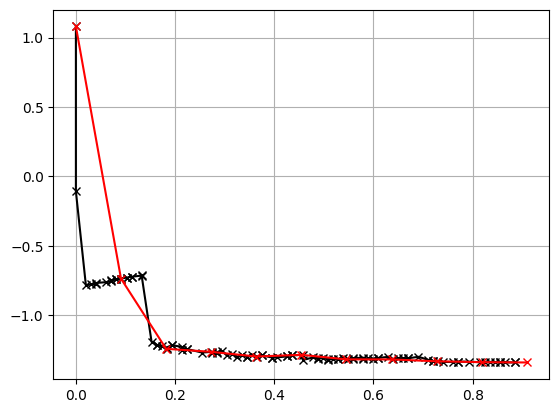

In [12]:
# Nearest neigbour interpolation
# resample with 20 hz starting from start_ts
# start_ts = vel_pd.Time[0]
start_ts = df_sim_ekf_state.Time[0]
max_duration = 1 # s
end_ts = start_ts + max_duration
# resampled = resample(vel_pd, 1/11.0, start_ts, end_ts,  method="nearest")
resampled = resample(df_sim_ekf_state, 1/11.0, start_ts, end_ts,  method="nearest")
# plt.plot(vel_pd.Time - start_ts, vel_pd.velocity_0, "kx-")
plt.plot(df_sim_ekf_state.Time - start_ts, df_sim_ekf_state.x, "kx-")
plt.plot(resampled.Time - start_ts, resampled.x, "rx-")
# plt.plot(resampled.Time - start_ts, resampled.velocity_0, "rx-")
plt.grid()

Interpolating with Ts step  0.09090909090909091  for  1.0 s using interpolation method linear


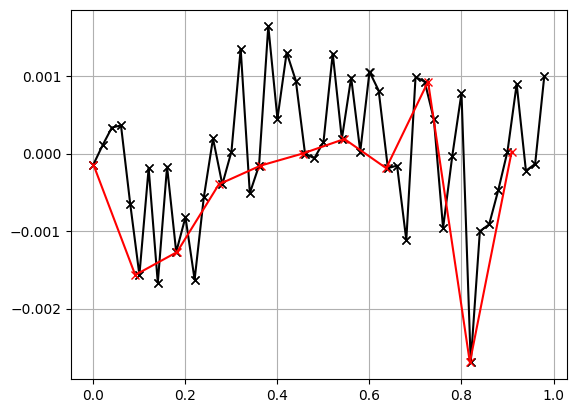

In [5]:
# Nearest neigbour interpolation
# resample with 20 hz starting from start_ts
start_ts = vel_pd.Time[0]
max_duration = 1 # s
end_ts = start_ts + max_duration
resampled = resample(vel_pd, 1/11.0, start_ts, end_ts,  method="linear")
plt.plot(vel_pd.Time - start_ts, vel_pd.velocity_0, "kx-")
plt.plot(resampled.Time - start_ts, resampled.velocity_0, "rx-")
plt.grid()

Interpolating with Ts step  [1708517995.1939585, 1708517995.2939587, 1708517995.6939585, 1708517995.9939587]  for  0.9799551963806152 s using interpolation method linear


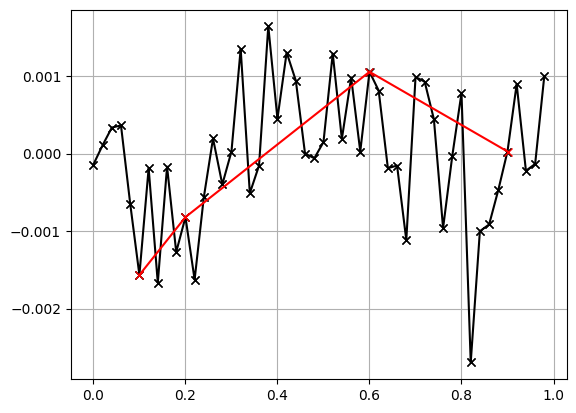

In [6]:
# Interpolate for given timestamps
start_ts = vel_pd.Time[0]
timestamps = [start_ts + 0.1, start_ts + 0.2, start_ts+0.6, start_ts+0.9]
resampled = resample(vel_pd, timestamps, start_ts, None,  "linear")
plt.plot(vel_pd.Time - start_ts, vel_pd.velocity_0, "kx-")
plt.plot(resampled.Time - start_ts, resampled.velocity_0, "rx-")
plt.grid()
